/var/folders/jp/_t5jnvzs2_1_k9zqwdy099500000gn/T/ipykernel_89653/4065611302.py:75: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


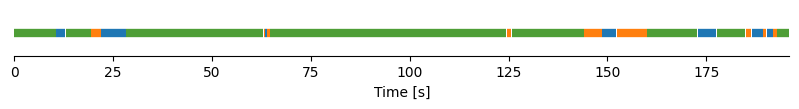

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

# === 入力 ===
xlsx_path = 'Behavioral_type.xlsx'
df = pd.read_excel(xlsx_path)

# 必須カラムの確認
assert 'Delta' in df.columns and 'BehavType' in df.columns, "Delta と BehavType 列が必要です。"

# 時間でソート & 必要列だけ
df = df[['Delta', 'BehavType']].dropna(subset=['Delta']).sort_values('Delta').reset_index(drop=True)

# === 色マップ定義（指定カラー: 16進コードを#付きで） ===
fixed_colors = {
    1: '#4E9E36',  # 緑
    3: '#0471BD',  # 青
    2: '#EBB51E',  # オレンジ
    4: '#6D2FA0'   # 紫
}
auto_palette = cycle(plt.cm.tab10.colors)  # 予備
color_map = {}
for bt in df['BehavType'].dropna().unique():
    if bt in fixed_colors:
        color_map[bt] = fixed_colors[bt]
    else:
        color_map[bt] = next(auto_palette)

# === 同一 BehavType の連続区間を抽出 ===
segments = []
curr_bt = None
start_t = None
prev_t = None

for t, bt in df[['Delta', 'BehavType']].to_numpy():
    if pd.isna(bt):
        if curr_bt is not None:
            segments.append((start_t, prev_t, curr_bt))
            curr_bt, start_t = None, None
    else:
        if curr_bt is None:
            curr_bt, start_t = bt, t
        elif bt != curr_bt:
            segments.append((start_t, prev_t, curr_bt))
            curr_bt, start_t = bt, t
    prev_t = t

if curr_bt is not None:
    segments.append((start_t, prev_t, curr_bt))

# === プロット（カラーバー） ===
fig, ax = plt.subplots(figsize=(10, 0.6))

for s, e, bt in segments:
    if s == e:
        continue
    ax.hlines(0, s, e, colors=color_map.get(bt, 'gray'), linewidth=6)

# 軸設定（25秒刻み）
xmin = float(df['Delta'].min())
xmax = float(df['Delta'].max())
ax.set_xlim(xmin, xmax)

tick_start = 25 * np.ceil(xmin / 25.0)
ticks = np.arange(tick_start, xmax + 0.1, 25.0)
ax.set_xticks(ticks)
ax.set_xlabel('Time [s]')

ax.get_yaxis().set_visible(False)
for spine in ['top', 'left', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig('color_bar_from_BehavType_custom.png', dpi=300, bbox_inches='tight')
plt.show()


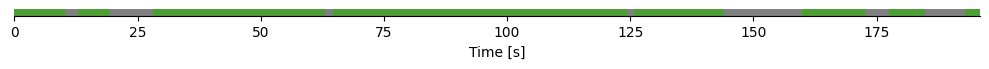

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

df = pd.read_excel('Behavioral_type.xlsx')[['Delta','BehavType']].sort_values('Delta').reset_index(drop=True)
fixed_colors = {1:'#4E9E36', 2:'#0471BD', 3:'#EBB51E', 4:'#6D2FA0'}

t = df['Delta'].to_numpy()
dt = np.diff(t)
dt_med = np.median(dt) if len(dt)>0 else 0.1
edges = np.concatenate(([t[0]-dt_med/2], (t[:-1]+t[1:])/2, [t[-1]+dt_med/2]))

segments = []
bt_arr = df['BehavType'].to_numpy()
start_idx = 0
for i in range(1, len(bt_arr)):
    if bt_arr[i] != bt_arr[start_idx]:
        segments.append((edges[start_idx], edges[i], bt_arr[start_idx]))
        start_idx = i
segments.append((edges[start_idx], edges[len(bt_arr)], bt_arr[start_idx]))

fig, ax = plt.subplots(figsize=(10, 0.8))
for s, e, bt in segments:
    color = fixed_colors.get(bt, 'gray')
    ax.add_patch(Rectangle((s, -0.5), e - s, 1.0, linewidth=0, facecolor=color))

# 軸設定（25秒刻み）
xmin, xmax = float(t.min()), float(t.max())
ax.set_xlim(xmin, xmax)
ax.set_ylim(-0.5, 0.5)
tick_start = 25 * np.ceil(xmin/25.0)
ax.set_xticks(np.arange(tick_start, xmax+0.1, 25.0))
ax.set_yticks([])
ax.set_xlabel('Time [s]')

for sp in ['top','left','right']:
    ax.spines[sp].set_visible(False)

plt.tight_layout()
plt.savefig('color_bar_no_gap_C_rect.png', dpi=300, bbox_inches='tight')
plt.show()


AttributeError: LineCollection.set() got an unexpected keyword argument 'solid_capstyle'

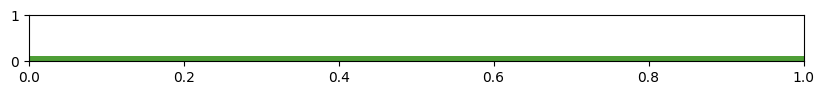

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === 入力 ===
df = pd.read_excel('Behavioral_type.xlsx')[['Delta','BehavType']].sort_values('Delta').reset_index(drop=True)

# === 色定義 ===
fixed_colors = {1:'#4E9E36', 2:'#0471BD', 3:'#EBB51E', 4:'#6D2FA0'}

# === 区間エッジ（ビン境界）を作る：隣接時刻の中点を境界にする ===
t = df['Delta'].to_numpy()
dt = np.diff(t)
dt_med = np.median(dt) if len(dt)>0 else 0.1
edges = np.concatenate(([t[0]-dt_med/2], (t[:-1]+t[1:])/2, [t[-1]+dt_med/2]))

# === 同一BehavTypeの連続区間を抽出（エッジ基準で閉区間化）===
segments = []
bt_arr = df['BehavType'].to_numpy()
start_idx = 0
for i in range(1, len(bt_arr)):
    if bt_arr[i] != bt_arr[start_idx]:
        segments.append((edges[start_idx], edges[i], bt_arr[start_idx]))
        start_idx = i
segments.append((edges[start_idx], edges[len(bt_arr)], bt_arr[start_idx]))

# === 描画 ===
fig, ax = plt.subplots(figsize=(10, 0.6))
for s, e, bt in segments:
    color = fixed_colors.get(bt, 'gray')
    ax.hlines(0, s, e, colors=color, linewidth=6,
              antialiased=False, solid_capstyle='butt')  # ←にじみ＆端丸め対策

# 軸設定（25秒刻み）
xmin, xmax = float(t.min()), float(t.max())
ax.set_xlim(xmin, xmax)
tick_start = 25 * np.ceil(xmin/25.0)
ax.set_xticks(np.arange(tick_start, xmax+0.1, 25.0))
ax.set_xlabel('Time [s]')

ax.get_yaxis().set_visible(False)
for sp in ['top','left','right']:
    ax.spines[sp].set_visible(False)

plt.tight_layout()
plt.savefig('color_bar_no_gap_A_hlines.png', dpi=300, bbox_inches='tight')
plt.show()


AttributeError: LineCollection.set() got an unexpected keyword argument 'solid_capstyle'

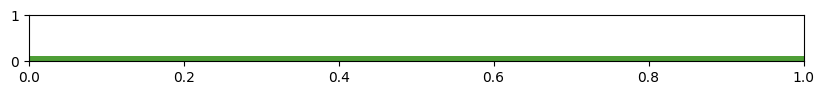

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_excel('Behavioral_type.xlsx')[['Delta','BehavType']].sort_values('Delta').reset_index(drop=True)
fixed_colors = {1:'#4E9E36', 2:'#0471BD', 3:'#EBB51E', 4:'#6D2FA0'}

t = df['Delta'].to_numpy()
dt = np.diff(t)
dt_med = np.median(dt) if len(dt)>0 else 0.1
edges = np.concatenate(([t[0]-dt_med/2], (t[:-1]+t[1:])/2, [t[-1]+dt_med/2]))

segments = []
bt_arr = df['BehavType'].to_numpy()
start_idx = 0
for i in range(1, len(bt_arr)):
    if bt_arr[i] != bt_arr[start_idx]:
        segments.append((edges[start_idx], edges[i], bt_arr[start_idx]))
        start_idx = i
segments.append((edges[start_idx], edges[len(bt_arr)], bt_arr[start_idx]))

epsilon = dt_med / 10.0  # ごく小さく重ねる

fig, ax = plt.subplots(figsize=(10, 0.6))
for s, e, bt in segments:
    color = fixed_colors.get(bt, 'gray')
    ax.hlines(0, s - epsilon, e + epsilon, colors=color, linewidth=6,
              antialiased=False, solid_capstyle='butt')

xmin, xmax = float(t.min()), float(t.max())
ax.set_xlim(xmin, xmax)
tick_start = 25 * np.ceil(xmin/25.0)
ax.set_xticks(np.arange(tick_start, xmax+0.1, 25.0))
ax.set_xlabel('Time [s]')

ax.get_yaxis().set_visible(False)
for sp in ['top','left','right']:
    ax.spines[sp].set_visible(False)

plt.tight_layout()
plt.savefig('color_bar_no_gap_B_overlap.png', dpi=300, bbox_inches='tight')
plt.show()


/var/folders/jp/_t5jnvzs2_1_k9zqwdy099500000gn/T/ipykernel_89653/141433908.py:41: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


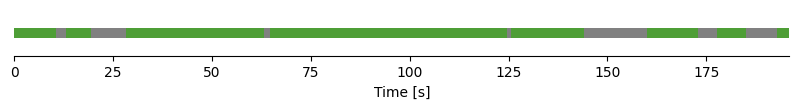

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_excel('Behavioral_type.xlsx')[['Delta','BehavType']].sort_values('Delta').reset_index(drop=True)
fixed_colors = {1:'#4E9E36', 2:'#0471BD', 3:'#EBB51E', 4:'#6D2FA0'}

t_raw = df['Delta'].to_numpy()
dt = np.diff(t_raw)
dt_med = np.median(dt) if len(dt)>0 else 0.1
grid = dt_med / 10.0  # 細かいが有限なグリッドへ丸め

t = np.round(t_raw / grid) * grid
order = np.argsort(t)
t = t[order]
bt = df['BehavType'].to_numpy()[order]

segments = []
sidx = 0
for i in range(1, len(bt)):
    if bt[i] != bt[sidx]:
        segments.append((t[sidx], t[i], bt[sidx]))
        sidx = i
segments.append((t[sidx], t[-1] + grid, bt[sidx]))  # 終端を1グリッド延長

fig, ax = plt.subplots(figsize=(10, 0.6))
for s, e, b in segments:
    ax.hlines(0, s, e, colors=fixed_colors.get(b,'gray'), linewidth=6,
              capstyle='butt', antialiaseds=False)

xmin, xmax = float(t.min()), float(t.max())
ax.set_xlim(xmin, xmax)
tick_start = 25 * np.ceil(xmin/25.0)
ax.set_xticks(np.arange(tick_start, xmax+0.1, 25.0))
ax.set_xlabel('Time [s]')

ax.get_yaxis().set_visible(False)
for sp in ['top','left','right']:
    ax.spines[sp].set_visible(False)

plt.tight_layout()
plt.savefig('color_bar_no_gap_D_quantized.png', dpi=300, bbox_inches='tight')
plt.show()


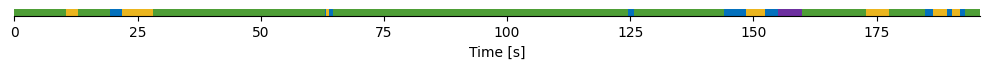

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# === 入力 ===
xlsx_path = 'Behavioral_type.xlsx'
df = pd.read_excel(xlsx_path)[['Delta', 'BehavType']].dropna(subset=['Delta']).sort_values('Delta').reset_index(drop=True)

# === 色マップ（指定どおり） ===
fixed_colors = {
    -1: '#EBB51E',  # オレンジ
     0: '#0471BD',  # 青
     1: '#4E9E36',  # 緑
     2: '#6D2FA0',  # 紫
}

# === 連続区間を「サンプル中点のエッジ」で作成（白い隙間防止） ===
t = df['Delta'].to_numpy()
bt = df['BehavType'].to_numpy()

# サンプル時刻が一つだけの場合のフォールバック
if len(t) == 1:
    dt_med = 0.1
    edges = np.array([t[0] - dt_med/2, t[0] + dt_med/2])
else:
    dt = np.diff(t)
    dt_med = np.median(dt) if len(dt) > 0 else 0.1
    edges = np.concatenate(([t[0] - dt_med/2], (t[:-1] + t[1:]) / 2, [t[-1] + dt_med/2]))

# 同一ラベルの連続区間へ圧縮
segments = []
start_idx = 0
for i in range(1, len(bt)):
    if bt[i] != bt[start_idx]:
        segments.append((edges[start_idx], edges[i], bt[start_idx]))
        start_idx = i
segments.append((edges[start_idx], edges[len(bt)], bt[start_idx]))

# === 描画（矩形で帯を塗る） ===
fig, ax = plt.subplots(figsize=(10, 0.8))

for s, e, b in segments:
    color = fixed_colors.get(b, '#A0A0A0')  # 未定義ラベルは灰色
    width = max(e - s, 0.0)
    if width <= 0:
        continue
    ax.add_patch(Rectangle((s, -0.5), width, 1.0, linewidth=0, facecolor=color))

# 軸設定：25秒刻み
xmin, xmax = float(t.min()), float(t.max())
ax.set_xlim(xmin, xmax)
ax.set_ylim(-0.5, 0.5)
tick_start = 25 * np.ceil(xmin / 25.0)
ax.set_xticks(np.arange(tick_start, xmax + 1e-9, 25.0))
ax.set_yticks([])
ax.set_xlabel('Time [s]')

# 余計な枠を消す
for sp in ['top', 'left', 'right']:
    ax.spines[sp].set_visible(False)

plt.tight_layout()
plt.savefig('color_bar_behavtype_rect.tif', dpi=300, bbox_inches='tight')
plt.show()
